#### 1.	Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

1. поправила learning_rate (проставлялась константа, а не значение переменной)
2. поправила проверку на тестовых данных
3. изменила F.sigmoid на torch.sigmoid
4. поправила маску в CustomDatasetFromImages

In [643]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

import time
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [644]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [645]:
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

In [646]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('Semantic segmentation for Self-driving Cars'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

In [647]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
df.sort_values(by='cameraRGB',inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)

,cameraRGB,cameraSeg
0,Semantic segmentation for Self-driving Cars\da...,Semantic segmentation for Self-driving Cars\da...
1,Semantic segmentation for Self-driving Cars\da...,Semantic segmentation for Self-driving Cars\da...
2,Semantic segmentation for Self-driving Cars\da...,Semantic segmentation for Self-driving Cars\da...
3,Semantic segmentation for Self-driving Cars\da...,Semantic segmentation for Self-driving Cars\da...
4,Semantic segmentation for Self-driving Cars\da...,Semantic segmentation for Self-driving Cars\da...


In [648]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 13):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 1, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [649]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [650]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [651]:
learning_rate = 0.001
epochs = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Umodel = UNet(num_classes=13).to(device)

optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 3500 total_steps per epoch


In [652]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score
    
criterion = SoftDiceLoss()

In [653]:
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
#         data = data.cuda()
#         labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Train Epoch: 1, Loss: -0.8982963569959005
Spend time for 300 images: 1597.7856016159058 sec
Train Epoch: 1, Loss: -0.954217909971873
Spend time for 300 images: 1507.1310617923737 sec
Train Epoch: 1, Loss: -0.9596679306030274
Spend time for 300 images: 1543.6887893676758 sec
Train Epoch: 1, Loss: -0.9588243567943573
Spend time for 300 images: 1516.0247766971588 sec
Train Epoch: 1, Loss: -0.9611960117022197
Spend time for 300 images: 1513.5868911743164 sec
Train Epoch: 1, Loss: -0.9648880747954051
Spend time for 300 images: 1547.0290627479553 sec
Train Epoch: 1, Loss: -0.9649804484844208
Spend time for 300 images: 1557.3759031295776 sec
Train Epoch: 1, Loss: -0.9644150344530741
Spend time for 300 images: 1519.2810680866241 sec
Train Epoch: 1, Loss: -0.9639593434333801
Spend time for 300 images: 1514.647042274475 sec
Train Epoch: 1, Loss: -0.9667211246490478
Spend time for 300 images: 1517.7947912216187 sec
Train Epoch: 1, Loss: -0.9635183481375377
Spend time for 300 images: 1519.92267847

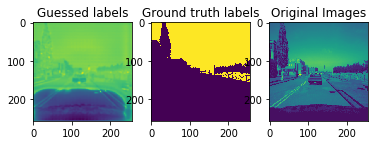

C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

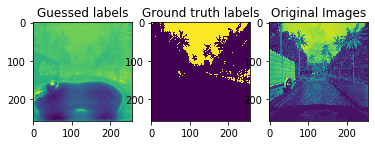

<Figure size 432x288 with 0 Axes>

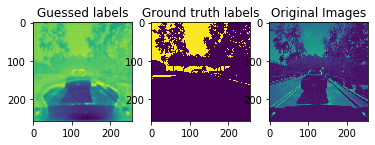

<Figure size 432x288 with 0 Axes>

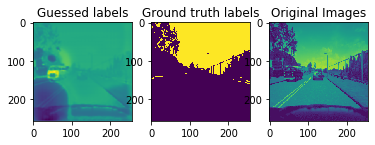

<Figure size 432x288 with 0 Axes>

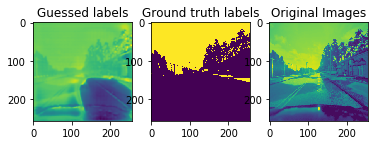

<Figure size 432x288 with 0 Axes>

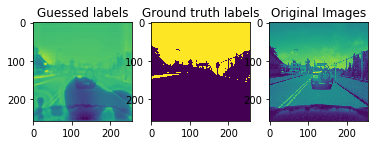

<Figure size 432x288 with 0 Axes>

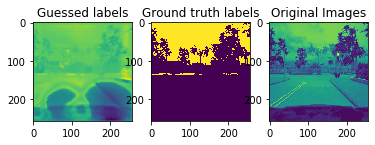

<Figure size 432x288 with 0 Axes>

In [654]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = Umodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach().cpu().numpy()[0, 0, :,:])
#     axarr[0].imshow(torch.argmax(outputs[0].detach().cpu().numpy()[1,:,:]))
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

#### 2.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на губы(т.е. 2 класса: губы/не губы).

#### 3.И затем обучить Модель на выбор из segmentation_models_pytorch

In [642]:
# !pip install segmentation_models_pytorch

In [369]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset as BaseDataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

import time
from torch.autograd import Variable

import segmentation_models_pytorch as smp

import cv2 as cv

import imageio

from sklearn.model_selection import train_test_split

In [204]:
nRowsRead = 1000 # specify 'None' if want to read whole file
df1 = pd.read_csv('./set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
df1.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
995,image00000996.jpg,1280,720,Lips,692,343,780,412,mask00000996.png
996,image00000997.jpg,1280,720,Lips,620,348,712,402,mask00000997.png
997,image00000998.jpg,1280,720,Lips,700,337,788,405,mask00000998.png
998,image00000999.jpg,1280,720,Lips,679,337,762,389,mask00000999.png
999,image00001000.jpg,1280,720,Lips,667,359,749,412,mask00001000.png


In [205]:
images = []
masks = []
for ind,rows in df1.iterrows():
    masks.append('./set-lipstick-original/mask/'+rows['mask'])
    images.append('./set-lipstick-original/720p/'+rows['filename'])

In [326]:
df = pd.DataFrame({'masks': masks, 'images': images})
df.sort_values(by='images',inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)

,masks,images
0,./set-lipstick-original/mask/mask00000001.png,./set-lipstick-original/720p/image00000001.jpg
1,./set-lipstick-original/mask/mask00000002.png,./set-lipstick-original/720p/image00000002.jpg
2,./set-lipstick-original/mask/mask00000003.png,./set-lipstick-original/720p/image00000003.jpg
3,./set-lipstick-original/mask/mask00000004.png,./set-lipstick-original/720p/image00000004.jpg
4,./set-lipstick-original/mask/mask00000005.png,./set-lipstick-original/720p/image00000005.jpg


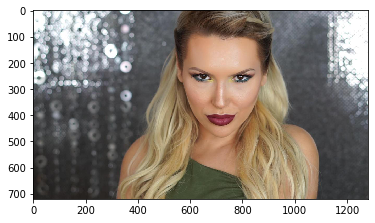

In [209]:
img = imageio.imread(images[0])
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

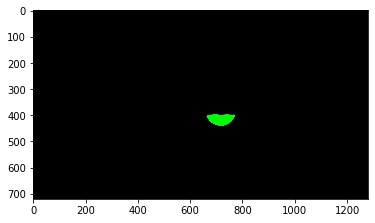

In [294]:
msk = imageio.imread(masks[0])
msk = msk.astype(np.float32) / 255.
_=plt.imshow(msk)

In [295]:
msk.shape

(720, 1280, 3)

In [296]:
np.unique(msk[:,:,0])

Array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23921569, 0.24313726, 0.24705882, 0.2509804 , 0.25490198,
       0.25882354, 0.2627451 , 0.26666668, 0.27058825, 0.2784314 ,
       0.28235295, 0.2901961 , 0.29411766, 0.29803923, 0.30588

In [297]:
np.unique(msk[:,:,0]*255)

Array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  71.,  72.,  74.,  75.,  76.,  78.,  86.,  93.,
       101.], dtype=float32)

In [298]:
len(np.unique(msk[:,:,0]*255))

78

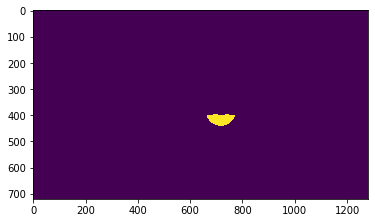

In [320]:
threshold = 0.3
img_bw_0 = np.mean(msk, axis=2)
img_bin = (img_bw_0 > threshold).astype(np.uint8)
_=plt.imshow(img_bin)

In [322]:
len(np.unique(img_bin*255))

2

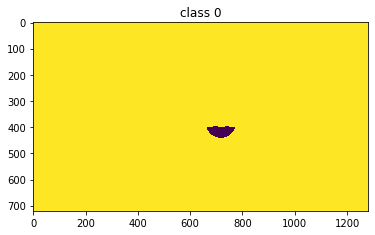

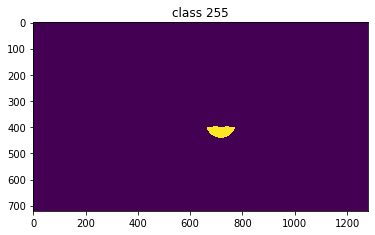

In [325]:
for i in np.unique(img_bin*255):
    mask = img_bin*255
    mask = np.where(mask == i, 255, 0)
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [602]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,1]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,0]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        #img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = imageio.imread(self.image_arr[index]).astype('float')
#         if (img.shape[0] != 720) or (img.shape[1] != 1280) or (img.shape[2] != 3):
#             print(img.shape)
        
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний       
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        threshold = 0.3
        lab = np.asarray(plt.imread(self.label_arr[index]))
        if (len(lab.shape) != 3):
            print(lab.shape)
        if (lab.shape[0] != 720) or (lab.shape[1] != 1280) or (lab.shape[2] != 3):
            print(lab.shape)
        lab = np.mean(lab, axis=2)
        lab = (lab < threshold).astype(np.uint8)
        
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)

        mask = lab*255
        x = torch.as_tensor(mask).unsqueeze(0)
        x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        mask = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        mask = F.interpolate(input=mask, size=256, mode='nearest')
       
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

In [603]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [604]:
train_data.__getitem__(0)[0].shape,train_data.__getitem__(0)[1].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 2, 256, 256]))

In [605]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=False)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


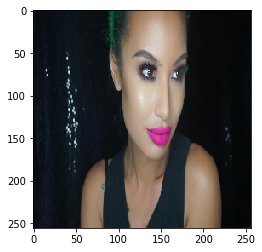

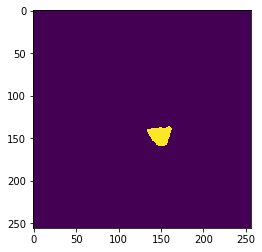

In [606]:
loader = iter(train_data_loader)
img, mask = loader.next()

plt.imshow((img[0][0]).permute(1, 2, 0))
plt.show()
plt.imshow((mask[0][0][0]))
plt.show()

In [607]:
labels = ['lips','not lips']

In [608]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1) #???
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score

In [609]:
learning_rate = 0.001
epochs = 1

segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=2, activation='softmax')
optimizer = torch.optim.Adam(segmodel.parameters(), lr=learning_rate)
dice_loss = SoftDiceLoss()

In [610]:
epoch_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = dice_loss(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1, loss:  -0.23138808224882398  time = 1104.5425024032593 sec


C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


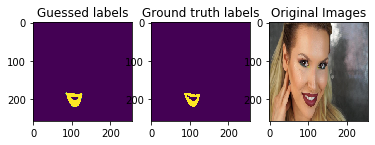

C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

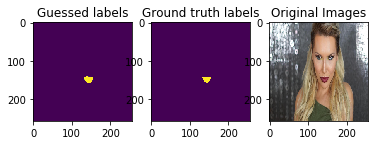

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

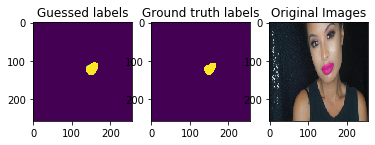

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

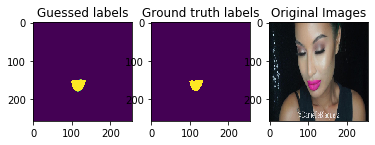

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

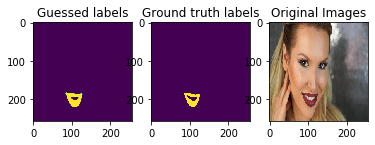

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

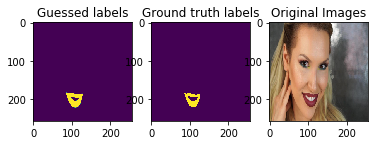

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

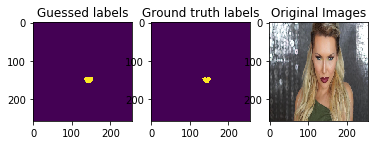

<Figure size 432x288 with 0 Axes>

In [641]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = segmodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach()[0][0].numpy())
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels.detach()[0][0][0].numpy())
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images.detach()[0][0].permute(1, 2, 0).numpy())
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break